 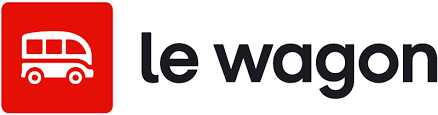

# Spotify clustering

In this challenge, we'll be using a dataset from Spotify that contains metadata for songs on the platform.

By metadata we mean info about the song such as name, artists, metrics about it's sound and other musical attributes.

We will use this dataset to try and cluster songs together that are closely related!

This is the underlying theory behind how recommender algorithms work on sites such as Spotify, Netflix, etc.

## Data Exploration

Please run the cell below to return the spotify song data!

In [1]:
import pandas as pd

spotify_df = pd.read_csv('https://wagon-public-datasets.s3.amazonaws.com/Machine%20Learning%20Datasets/ML_spotify_data.csv')
spotify_df.head()

,name,artists,popularity,danceability,valence,energy,explicit,key,liveness,loudness,speechiness,tempo
0,We're For The Dark - Remastered 2010,['Badfinger'],22,0.678,0.559,0.432,0,3,0.0727,-12.696,0.0334,117.674
1,Sixty Years On - Piano Demo,['Elton John'],25,0.456,0.259,0.368,0,6,0.1560,-10.692,0.0280,143.783
2,Got to Find Another Way,['The Guess Who'],21,0.433,0.833,0.724,0,0,0.1700,-9.803,0.0378,84.341
3,Feelin' Alright - Live At The Fillmore East/1970,['Joe Cocker'],22,0.436,0.870,0.914,0,5,0.8550,-6.955,0.0610,174.005
4,Caravan - Take 7,['Van Morrison'],23,0.669,0.564,0.412,0,7,0.4010,-13.095,0.0679,78.716


For the purposes of our analyses, we will only need the numeric features from our dataset. Select only these and save them in a variable called `spotify_numeric`

In [2]:
spotify_numeric = spotify_df.select_dtypes(include=['int64', 'float64'])

spotify_numeric.head()

,popularity,danceability,valence,energy,explicit,key,liveness,loudness,speechiness,tempo
0,22,0.678,0.559,0.432,0,3,0.0727,-12.696,0.0334,117.674
1,25,0.456,0.259,0.368,0,6,0.1560,-10.692,0.0280,143.783
2,21,0.433,0.833,0.724,0,0,0.1700,-9.803,0.0378,84.341
3,22,0.436,0.870,0.914,0,5,0.8550,-6.955,0.0610,174.005
4,23,0.669,0.564,0.412,0,7,0.4010,-13.095,0.0679,78.716


Have a read through your features and try to understand what they are related to!

Spotify generate their own features that relate to abstract characteristcs that can be attributed to a piece of music (e.g. 'valence' or 'danceability'), you don't need to worry about how these are calculated!

Then we also have some information that is more literal such as the 'key', 'tempo' and whether a song is 'explicit' or not.

Investiate the distributions of some of your variables below:

- What is the ratio of explicit vs non-explicit songs?
- How is popularity distributed?
- How are Spotify's internal song metrics distributed?

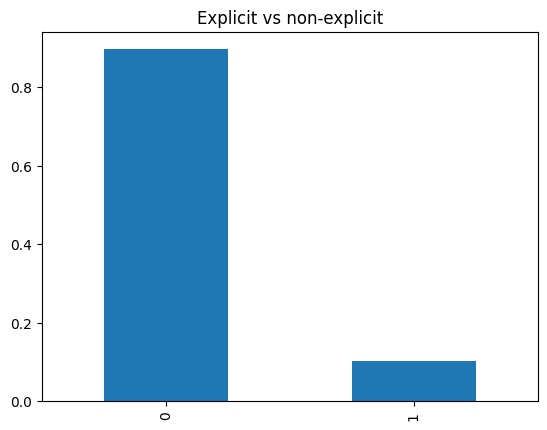

In [3]:
import matplotlib.pyplot as plt

spotify_numeric.explicit.value_counts(normalize=True).plot(kind='bar');
plt.title('Explicit vs non-explicit');

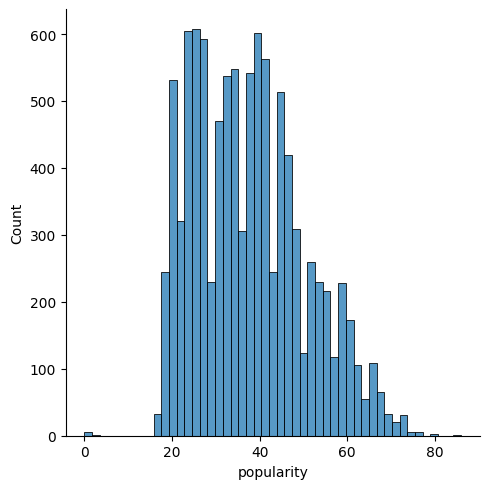

In [4]:
import seaborn as sns

sns.displot(spotify_numeric['popularity']);

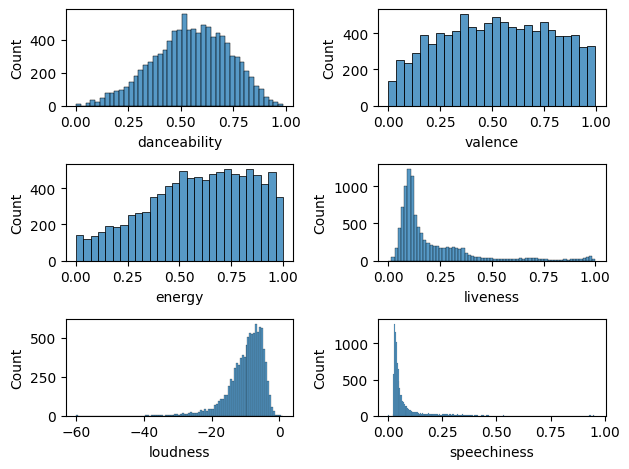

In [5]:
import numpy as np

fig, axs = plt.subplots(3, 2)

var_list = ['danceability', 'valence', 'energy', 'liveness', 'loudness', 'speechiness']

# Loop directly through the axs object and assign titles from the list
for row_axes, row_titles in zip(axs, np.array(var_list).reshape(3, 2)):
    for ax, title in zip(row_axes, row_titles):
        sns.histplot(x=spotify_numeric[title], ax=ax)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

The cell below will visualize three of your features in 3D space. Feel free to switch up the variables that are being used for the *x*, *y*, *z* axes.

Because we are using plotly express, you can use your cursor to move around / zoom in & out of the chart.

In [6]:
import plotly.express as px

fig = px.scatter_3d(spotify_numeric,
                    x='danceability',
                    y='energy',
                    z='speechiness',
                    opacity=0.7,
                    width=500,
                    height=500
           )
fig.show()

## First model

Our goal in this challenge is to cluster our songs into similar groups! The plot above may or may not reveal things that look like clusters, but remember! We can only visualise three of our variables here at a time.

When we train a clustering model it will cluster our songs in n-dimensional space, where n is the number of features being fed into the model.

Let's start by instantiating a simple KMeans model, with 8 clusters.

Fit this to your numeric spotify data and save the labels that your model has stored in a variable called `labels_simple`.

<details>
    <summary><i>Hint</i></summary>

To get the labels, have a look at the attributes your model has once it has been fitted to your data.
</details>

In [7]:
from sklearn.cluster import KMeans

kmeans_simple = KMeans(n_clusters=8, n_init='auto')
kmeans_simple.fit(spotify_numeric)

labels_simple = kmeans_simple.labels_
labels_simple

array([5, 2, 7, ..., 4, 4, 0], dtype=int32)

What is the distribution of our labels? How many songs do we have in each cluster?

In [8]:
np.unique(labels_simple,return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int32),
 array([1371, 1083, 1162, 1387,  648, 1781, 1322, 1246]))

We can also now visualise our songs in 3D space again, but this time colour them by our new labels to see what clusters we have created! Run the cell below to see how it's looking.

In [9]:
fig = px.scatter_3d(spotify_numeric,
                    x='danceability',
                    y='energy',
                    z='speechiness',
                    color=labels_simple,
                    width=500,
                    height=500)
fig.show()

It looks a little bit chaotic doesn't it... I'm not sure I'd be forking out the monthly suscription costs if my discover weekly was as all the place as this chart is.

Do you have any intuitions as to why our labels might look so poorly clustered?

<details>
    <summary><i>Answer</i></summary>

Remember that KMeans (and most unsupervised learning algorithms) are distance based. We have **not** scaled our numeric features yet. Perhaps doing this will make things look a bit clearer?
</details>

In the cell below, perform the preprocessing on our dataset that you deem necessary!

## Preprocessing

In [10]:
from sklearn.preprocessing import RobustScaler

# This might be a new type of scaler to you! Robust scaler is more... robust... to outliers in the
# data when normalizing. Some of our variables have very non-normal distrubutions.

scaler = RobustScaler()
spotify_scaled = pd.DataFrame(scaler.fit_transform(spotify_numeric),
                              columns=spotify_numeric.columns)
spotify_scaled

,popularity,danceability,valence,energy,explicit,key,liveness,loudness,speechiness,tempo
0,-0.736842,0.482072,0.080420,-0.475452,0.0,-0.285714,-0.336421,-0.626782,-0.270833,-0.015120
1,-0.578947,-0.402390,-0.618881,-0.640827,0.0,0.142857,0.161339,-0.307496,-0.395833,0.586217
2,-0.789474,-0.494024,0.719114,0.279070,0.0,-0.714286,0.244996,-0.165857,-0.168981,-0.782839
3,-0.736842,-0.482072,0.805361,0.770026,0.0,0.000000,4.338213,0.287899,0.368056,1.282283
4,-0.684211,0.446215,0.092075,-0.527132,0.0,0.285714,1.625336,-0.690353,0.527778,-0.912393
...,...,...,...,...,...,...,...,...,...,...
9995,1.894737,0.912351,0.194639,0.496124,0.0,0.285714,-0.279653,0.806182,0.995370,-0.306357
9996,1.684211,0.637450,0.488345,0.354005,0.0,0.285714,-0.167314,0.436868,0.356481,0.451550
9997,2.105263,0.306773,0.262238,0.625323,0.0,-0.142857,0.770840,1.041345,0.828704,-0.613624
9998,1.789474,0.454183,-0.768065,0.018088,1.0,-0.428571,3.071407,0.255078,6.085648,-0.996712


## Modelling with preprocessed data

Now, let's train and fit a model in the same way that we did above. However, this time we will use the scaled data! Save the labels in a variable called `labels_scaled`

In [11]:
kmeans_scaled = KMeans(n_clusters=8, n_init='auto')
kmeans_scaled.fit(spotify_scaled)

labels_scaled = kmeans_scaled.labels_
labels_scaled

array([4, 3, 4, ..., 0, 1, 0], dtype=int32)

Run the cell below to see how our clusters look in 3D space, but with our newly scaled data.

In [12]:
fig_scaled = px.scatter_3d(spotify_scaled,
                           x='danceability',
                           y='energy',
                           z='speechiness',
                           color=labels_scaled,
                           width=500,
                           height=500)
fig_scaled.show()

## Finding the right value for *K*

It should look a bit more tidy, maybe a bit more stratified! Progress!

**However, it still doesn't look perfect**. Remember though, we are only looking at 3 dimensions out of the 10 dimensions that our model is trained on.

It might be that, if we could visualise 10 dimensionsal space, we would see some much more intuitively shaped clusters!

So far we have been using 8 clusters for our models so far, but we havented tested whether this makes sense.

Let's use *the elbow method* to check how many of clusters we should ideally be using for this dataset. Do this below. Remember to use a plot to visualise your results.



In [13]:
nb_clusters_to_try = np.arange(1, 21, 1)
nb_clusters_to_try

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20])

In [14]:
inertias = []

for k in nb_clusters_to_try:
    kmeans = KMeans(n_clusters=k, n_init='auto')
    kmeans.fit(spotify_scaled)
    inertias.append(kmeans.inertia_)

inertias

[100388.99587726666,
 63515.02952245799,
 55856.550539637574,
 47978.21483878055,
 38653.068960120785,
 35065.12114419053,
 32596.436807899867,
 30810.270405794414,
 29484.158619397116,
 28162.500098158103,
 27472.504007912794,
 26130.451619445306,
 25668.309846267635,
 25017.79716257381,
 24482.253234323704,
 24285.667722158927,
 23611.694903502514,
 23209.03648879767,
 22720.85729277242,
 22364.775026120293]

In [15]:
import plotly.express as px

fig = px.line(y=inertias,
              x=range(1, len(inertias) + 1),
              labels={'x': 'nb centroids', 'y':'Inertia'},
              title="Elbow method")
fig.show()

It looks as though have around 6 clusters makes sense with our dataset. Create a new KMeans model using 6 clusters and plot it in 3D space using the same process that we have done above.

## Creating a model with the ideal number of clusters

In [16]:
spotify_clusters = 6

kmeans = KMeans(n_clusters=spotify_clusters, n_init='auto', max_iter=300)

kmeans.fit(spotify_scaled)

labelling = kmeans.labels_

fig_scaled = px.scatter_3d(spotify_scaled,
                           x='danceability',
                           y='energy',
                           z='speechiness',
                           color=labels_scaled,
                           width=500,
                           height=500)
fig_scaled.show()

The chart doesn't reveal a whole lot more, but perhaps we can create some theoretical playlists based on our clusters?

Add the new labels from our model that has 6 clusters to our original spotify dataframe as a column called 'label'.

In [17]:
spotify_df['label'] = pd.Series(labelling)

spotify_df.head()

,name,artists,popularity,danceability,valence,energy,explicit,key,liveness,loudness,speechiness,tempo,label
0,We're For The Dark - Remastered 2010,['Badfinger'],22,0.678,0.559,0.432,0,3,0.0727,-12.696,0.0334,117.674,3
1,Sixty Years On - Piano Demo,['Elton John'],25,0.456,0.259,0.368,0,6,0.1560,-10.692,0.0280,143.783,0
2,Got to Find Another Way,['The Guess Who'],21,0.433,0.833,0.724,0,0,0.1700,-9.803,0.0378,84.341,3
3,Feelin' Alright - Live At The Fillmore East/1970,['Joe Cocker'],22,0.436,0.870,0.914,0,5,0.8550,-6.955,0.0610,174.005,4
4,Caravan - Take 7,['Van Morrison'],23,0.669,0.564,0.412,0,7,0.4010,-13.095,0.0679,78.716,3


## Generating Spotify playlists based on our clusters!

We should now see the original meta-data for our spotify songs, but **with the added label of which cluster they are located in** based on our KMeans algorithm

Let's generate 6 playlists (one for each cluster) that contains 15 random songs from that cluster.

Below we have created a dictionary called `daily_mixes`. Inside this dictionary we want to store keys that are the name of the cluster labels, and then as values we want dataframes that only contains the songs from that specific cluster.

Finish the for loop below to obtain this dictionary!

In [18]:
daily_mixes = {}

for num_cluster in np.unique(labelling):

  daily_mixes[num_cluster] = spotify_df[spotify_df['label'] == num_cluster]

Run the cell below to print out our 6 playlists!!!

In [19]:
for key,value in daily_mixes.items():
  print("-" * 50)
  print(f"Here are some songs for playlist {key}")
  print("-" * 50)
  display(value.sample(5)[['name', 'artists']])

--------------------------------------------------
Here are some songs for playlist 0
--------------------------------------------------


,name,artists
3182,Almaz,['Randy Crawford']
572,Down Where the Valley Are Low - Remastered Ver...,['Judee Sill']
4428,A Little Rain,['Tom Waits']
5042,Snowplay - Instrumental,['Thomas Newman']
1927,Autumn of Our Love,['Spyro Gyra']


--------------------------------------------------
Here are some songs for playlist 1
--------------------------------------------------


,name,artists
4295,Another One Bites The Dust - Live at Wembley '86,['Queen']
5071,A Who Seh Ne Dun (Wake De Man),['Cutty Ranks']
5145,Disco Devil,"['Lee ""Scratch"" Perry']"
9700,That's Why I Love You (feat. Sabrina Claudio),"['SiR', 'Sabrina Claudio']"
2134,Birth Day,"['LIL PLUMP', 'RICH FVCE']"


--------------------------------------------------
Here are some songs for playlist 2
--------------------------------------------------


,name,artists
310,Remarks by Reverend C L. Franklin,['Aretha Franklin']
1774,Grandpa Funk,['Robin Williams']
7770,Drag Queens and Goth People,['John Mulaney']
1330,Jack and the Beanstalk,['The Sesame Street Cast']
2421,I Had Lost My Mind,['Daniel Johnston']


--------------------------------------------------
Here are some songs for playlist 3
--------------------------------------------------


,name,artists
7281,Love Moves in Mysterious Ways - Live,['Nina']
6870,Greener,['Tally Hall']
1327,My Rose,['Enchantment']
304,Wild Child - Remastered,['Lou Reed']
4347,Get Out of Control,['Daniel Ash']


--------------------------------------------------
Here are some songs for playlist 4
--------------------------------------------------


,name,artists
3274,Joy to the World,['Percy Faith & His Orchestra & Chorus']
4029,Separate Lives - Live from the Serious Tour 19...,['Phil Collins']
5500,Maybe I'm Wrong,['Blues Traveler']
715,Domino - Live,['Van Morrison']
3096,I'm Alive,['W.A.S.P.']


--------------------------------------------------
Here are some songs for playlist 5
--------------------------------------------------


,name,artists
2596,Fix Me,['Black Flag']
9468,Money Bag,['Cardi B']
5942,Don't Leave Me - Live/1999,['blink-182']
7989,All I Want Is You,['Mac Miller']
7009,Big Poppa,['Mindless Self Indulgence']


### Running clustering with DBSCAN

As a bonus, let's try and run a clustering analysis using [DBSCAN](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html)!

Remember, with `DBSCAN` we don't need to *a-prior* select the number of clusters we will end up with.

Instantiate and fit a `DBSCAN` model. Read the documentation and be sure to trial out different values for `epsilon` and `min_samples` - **this is essential to return reasonable results!** [This article](https://medium.com/@tarammullin/dbscan-parameter-estimation-ff8330e3a3bd) has some helpful tips on how to help pick reasonable values

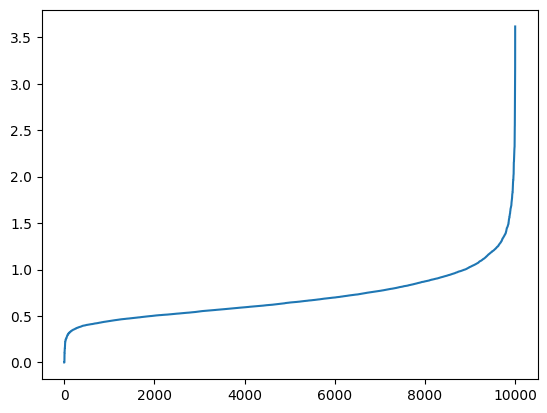

In [20]:
# Finding the ideal value for epsilon

from sklearn.neighbors import NearestNeighbors

neighbors = NearestNeighbors(n_neighbors=20)
neighbors_fit = neighbors.fit(spotify_scaled)
distances, indices = neighbors_fit.kneighbors(spotify_scaled)

distances = np.sort(distances, axis=0)
distances = distances[:, 1]
plt.plot(distances);

# Main crook occurs at approx. between 1 & 1.5 - you could loop through these values!

epsilon = 1.25

In [21]:
from sklearn.cluster import DBSCAN

# Min samples estimate is calculate here as n_features * 2
min_samples = len(spotify_scaled.columns) * 2

spotify_dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)

spotify_dbscan.fit(spotify_scaled)

DBSCAN(eps=1.25, min_samples=20)

How many clusters has the model created? What is their distribution? Save your labels in a variable called `dbscan_labels`. Is this the same as what we came up with using the Elbow Method?

In [22]:
dbscan_labels = spotify_dbscan.labels_

np.unique(dbscan_labels, return_counts=True)

(array([-1,  0,  1,  2,  3]), array([1506, 8370,   70,   21,   33]))

Run the cell below to plot your clusters using the DBSCAN labels.

In [23]:
fig_dbscan = px.scatter_3d(spotify_scaled,
                           x='danceability',
                           y='energy',
                           z='speechiness',
                           color=dbscan_labels,
                           width=500,
                           height=500)
fig_dbscan.show()

Using your fitted model, add in your predicted cluster labels for each song to the spotify dataframe in a new column called 'label_dbscan'

<details>
    <summary><i>Hint</i></summary>

Your number of clusters will be very dependent on the parameters you specified when instantiaing your model!
</details>

In [24]:
spotify_df['label_dbscan'] = pd.Series(dbscan_labels)

spotify_df.head()

,name,artists,popularity,danceability,valence,energy,explicit,key,liveness,loudness,speechiness,tempo,label,label_dbscan
0,We're For The Dark - Remastered 2010,['Badfinger'],22,0.678,0.559,0.432,0,3,0.0727,-12.696,0.0334,117.674,3,0
1,Sixty Years On - Piano Demo,['Elton John'],25,0.456,0.259,0.368,0,6,0.1560,-10.692,0.0280,143.783,0,0
2,Got to Find Another Way,['The Guess Who'],21,0.433,0.833,0.724,0,0,0.1700,-9.803,0.0378,84.341,3,0
3,Feelin' Alright - Live At The Fillmore East/1970,['Joe Cocker'],22,0.436,0.870,0.914,0,5,0.8550,-6.955,0.0610,174.005,4,0
4,Caravan - Take 7,['Van Morrison'],23,0.669,0.564,0.412,0,7,0.4010,-13.095,0.0679,78.716,3,0


In [25]:
spotify_df.label_dbscan.value_counts()

 0    8370
-1    1506
 1      70
 3      33
 2      21
Name: label_dbscan, dtype: int64

The cell below will generate some new playlists using the DBSCAN clusters!

In [26]:
daily_mixes_dbscan = {}

for num_cluster in np.unique(dbscan_labels):

  daily_mixes_dbscan[num_cluster] = spotify_df[spotify_df['label_dbscan'] == num_cluster]


for key,value in daily_mixes_dbscan.items():
  print("-" * 50)
  print(f"Here are some songs for playlist {key}")
  print("-" * 50)
  display(value.sample(5)[['name', 'artists']])

--------------------------------------------------
Here are some songs for playlist -1
--------------------------------------------------


,name,artists
3858,"Kid Vs. Play (The Battle) - From ""House Party""...","[""Kid 'N Play""]"
5694,Climb,"['Mos Def', 'Vinia Mojica']"
2756,Answering Machine,['The Replacements']
3843,He'll Do It Again,['Shirley Caesar']
1050,William Tell Overture,['Glen Campbell']


--------------------------------------------------
Here are some songs for playlist 0
--------------------------------------------------


,name,artists
7338,Born To Raise Hell,['Motörhead']
9141,Oops (feat. Charlie Puth),"['Little Mix', 'Charlie Puth']"
5088,Goodnight Sweetheart,['David Kersh']
6301,Cold Shot,['Stevie Ray Vaughan']
2711,Turn on the News,['Hüsker Dü']


--------------------------------------------------
Here are some songs for playlist 1
--------------------------------------------------


,name,artists
5123,Section,['The Roots']
9209,Grown Man Sport,"['Pete Rock', 'InI']"
7232,1 Mo Time,['Plies']
5544,Coming From,"['DMX', 'Mary J. Blige']"
8793,Shoot Me Down (feat. Anthony Stewart),"['G-Eazy', 'Anthony Stewart']"


--------------------------------------------------
Here are some songs for playlist 2
--------------------------------------------------


,name,artists
9174,"Ella y Yo (Remix) [feat. Farruko, Ozuna, Arcan...","['Pepe Quintana', 'Farruko', 'Ozuna', 'Arcange..."
9954,Mean,"['$NOT', 'Flo Milli']"
9812,Painless 2 (with NAV feat. Lil Durk),"['J.I the Prince of N.Y', 'NAV', 'Lil Durk']"
9030,Money over Everything,['A Boogie Wit da Hoodie']
9873,All Bad (feat. Lil Uzi Vert),"['Future', 'Lil Uzi Vert']"


--------------------------------------------------
Here are some songs for playlist 3
--------------------------------------------------


,name,artists
8694,Bullyar,['Cartel De Santa']
9920,SKYBOX,['Gunna']
9743,Like It (with 6LACK),"['Summer Walker', '6LACK']"
9438,4 Min Convo (Favorite Song),['A Boogie Wit da Hoodie']
9519,Mileage (feat. Chief Keef),"['Playboi Carti', 'Chief Keef']"


You've just completed your first unsupervised clustering! **Congrats**! This is a *very* commonplace methodology, especially in recommender systems.

By no means is the example we have gone through meant to be perfect (especially with a subjective topic such as music + limited features), and it can churn out some pretty chaotic results, but **the principles will very much hold true for all clustering tasks**.

Importantly, *never forgot to scale your data if you are using a distance-based algorithm*!

Finally, here are some links to more information about Spotify data / the Spotify API (perhaps some project inspiration)

- [Audio Analysis theory with the Spotify Web API](https://www.youtube.com/watch?v=goUzHd7cTuA)
- Spotify API [docs](https://developer.spotify.com/documentation/web-api/)
- Spotify API Wrappers [Tekore](https://github.com/felix-hilden/tekore) and [Spotipy](https://github.com/plamere/spotipy)